In [1]:
from feature_78_generation import *

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from graph_measures import *

In [4]:
finished_paths, unfinished_paths = load_paths(unquote_names=False, drop_timeouts=True)
nodes = pd.read_csv(GRAPH_METRICS_PATH)
metrics_dict = compute_path_metrics_w_nodes(
    nodes, unfinished_paths 
)

Total of paths:  19661
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_Lic

In [22]:
metrics_dict

{'path_degree': 0                            [158, 197, 134]
 1                                  [59, 129]
 2                        [298, 154, 586, 38]
 3        [40, 392, 1092, 185, 228, 209, 494]
 4                   [8, 1845, 298, 133, 649]
                         ...                 
 19656          [42, 1845, 210, 444, 82, 126]
 19657      [41, 105, 102, 97, 221, 122, 109]
 19658                      [20, 61, 155, 72]
 19659                   [133, 1140, 870, 27]
 19660                [35, 286, 119, 14, 123]
 Length: 19661, dtype: object,
 'path_clustering': 0        [0.2561606205057768, 0.0782148965946198, 0.090...
 1                 [0.2270857814336075, 0.1218579234972677]
 2        [0.0443899351163158, 0.1108422482594668, 0.033...
 3        [0.1404639175257732, 0.0476889741682003, 0.029...
 4        [0.0925925925925925, 0.0184511889825535, 0.044...
                                ...                        
 19656    [0.2374562427071178, 0.0184511889825535, 0.109...
 19657   

<Axes: >

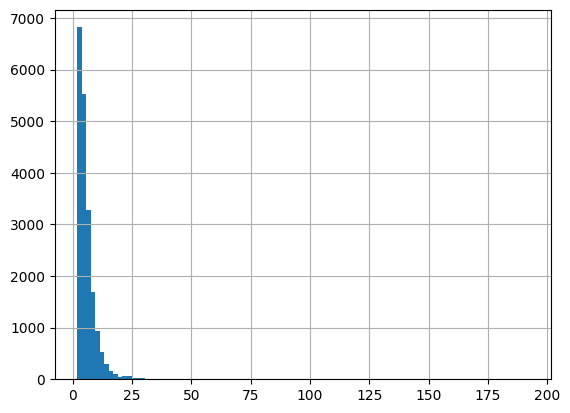

In [36]:
metrics_dict["path_degree"].apply(len).hist(bins=100)

In [29]:
too_short = 0
all_nan = 0
max_at_0 = 0
max_at_end = 0

for k,v in metrics_dict.items():
    print(f"Metric {k} of length {len(v)}")
    for i, val in enumerate(v):
        if len(val) < 3:
            too_short += 1
            continue
        if np.isnan(val).all():
            all_nan += 1
            continue
        if val[0] == np.nanmax(val):
            max_at_0 += 1
            continue
        if val[-1] == np.nanmax(val):
            max_at_end += 1
            continue

print(f"Too short: {too_short}")
print(f"All nan: {all_nan}")
print(f"Max at 0: {max_at_0}")
print(f"Max at end: {max_at_end}")
print(f"Total issues: {too_short + all_nan + max_at_0 + max_at_end}")
print(f"Total paths: {len(metrics_dict['path_degree'])}")

Metric path_degree of length 19661
Metric path_clustering of length 19661
Metric path_degree_centrality of length 19661
Metric path_betweenness of length 19661
Metric path_closeness of length 19661
Too short: 17900
All nan: 0
Max at 0: 9796
Max at end: 15100
Total issues: 42796
Total paths: 19661


In [26]:
metrics_slopes = compute_metric_slopes(metrics_dict, drop_na=False)

Adding slopes for path_degree
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too short
Path too s

In [24]:
metrics_slopes

[       slope_path_degree_before  slope_path_degree_after
 0                           NaN               -12.000000
 1                           NaN                      NaN
 2                           NaN               -34.800000
 3                           NaN                 4.714286
 4                           NaN               -43.000000
 ...                         ...                      ...
 19656                       NaN              -132.428571
 19657                       NaN                12.750000
 19658                       NaN                25.000000
 19659                       NaN               -58.800000
 19660                       NaN                -9.600000
 
 [19661 rows x 2 columns],
        slope_path_clustering_before  slope_path_clustering_after
 0                               NaN                    -0.082700
 1                               NaN                          NaN
 2                               NaN                     0.030645
 3         

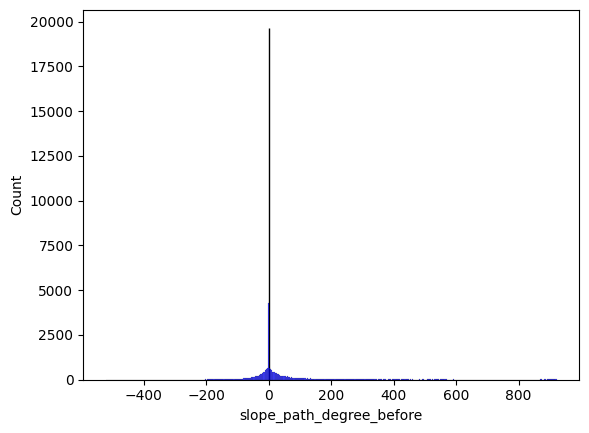

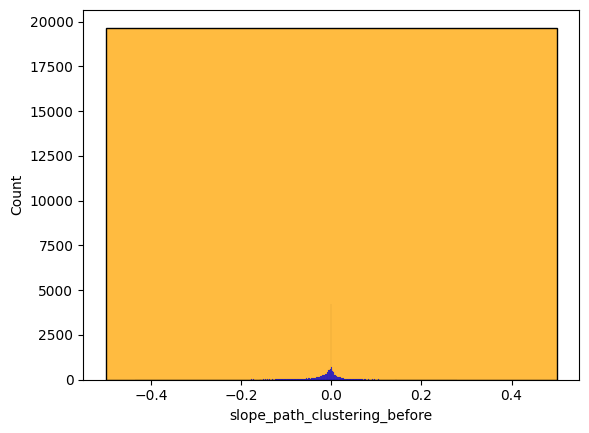

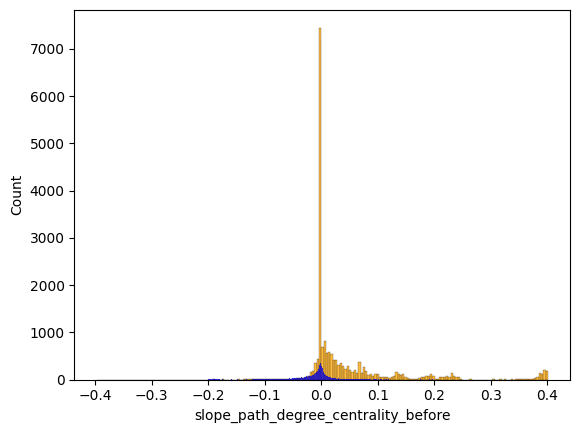

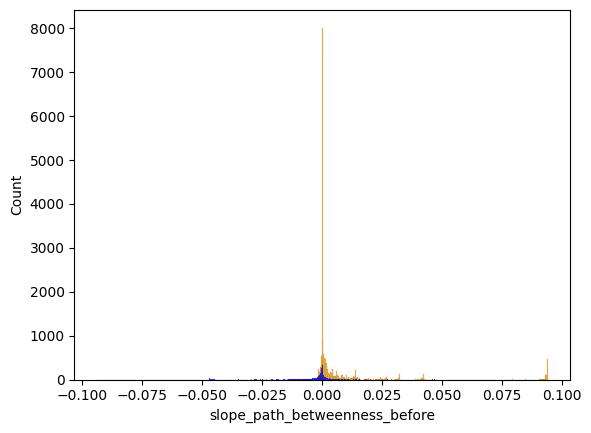

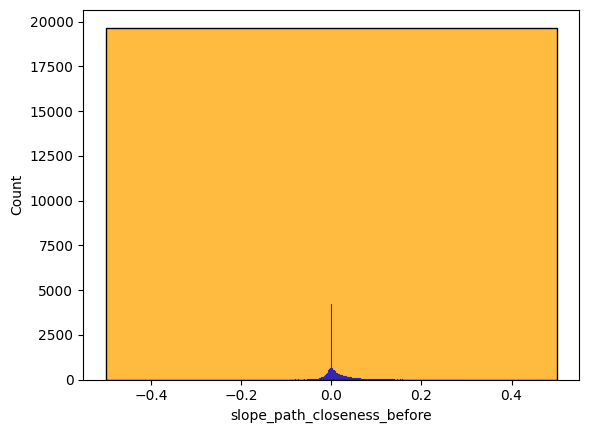

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
logging.getLogger().setLevel(logging.INFO)

for metric in metrics_slopes:
    metric = metric.fillna(0)
    sns.histplot(data=metric, x=metric.columns[0], color="orange")
    sns.histplot(data=metric, x=metric.columns[1], color="blue")
    plt.show()